In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
from numpy import linalg as LA

import warnings
warnings.filterwarnings("ignore")

def column(vector):
    return np.array(np.matrix(vector)).T

# Principal Components Analysis (PCA)

The folder *Faces* contains 974 images of people posing facial expressions and their respective landmarks ($n$ landmarks for each facial expression). Each landmark is a coordinate in two dimensions. The penultimate letter of the name of each file indicates what type of facial expression the person is posing. The notation is as follows: `n` for neutral, `h` for happy, `s` for sad, `a` for angry, `d` for disgust, and `f` for fear. We are only going to use the landmarks; the images are for referencing the landmarks.

### a) Procrustes Mean and Align Landmarks

In [2]:
dataDir = "Faces/markings/"
data = []
for file in os.listdir(dataDir) :
    data.append(scipy.io.loadmat(dataDir+file))

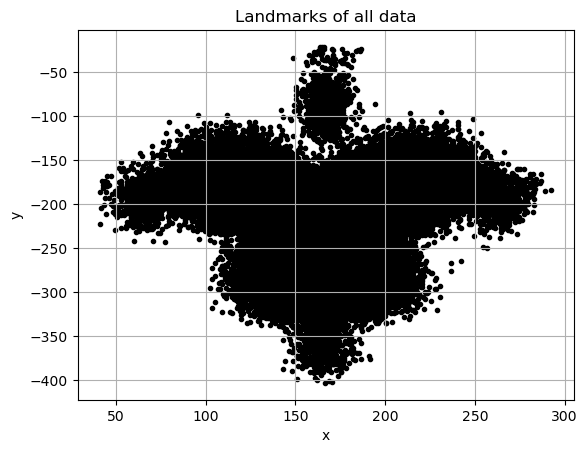

In [3]:
# Create a list to store all the data, and fill it
data_list = []

for i in range(len(data)):
    data_list.append(data[i]['faceCoordinatesUnwarped'])

plt.figure()
plt.grid()
for i in range(len(data_list)):
    plt.scatter(data_list[i][:,0], -data_list[i][:,1], color='black', marker='.')
plt.title('Landmarks of all data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


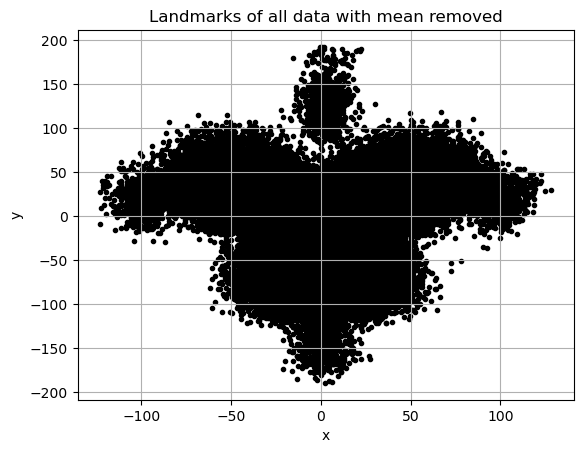

In [4]:
# Combine all the data into a single matrix of (974*67)x2
all_data = np.vstack(data_list)

# Real part of the data (coordsX)
real_part = column(all_data[:,0])

# Imaginary part of the data (coordsY)
imaginary_part = column(all_data[:,1])

# Remove the mean of each shape
mean_real = float(sum(real_part))/len(real_part)
mean_imaginary = float(sum(imaginary_part))/len(imaginary_part)

# Remove the mean from the data
real_part_without_mean = real_part - mean_real
imaginary_part_without_mean = imaginary_part - mean_imaginary

# Plot the landmarks with the mean removed
plt.figure()
plt.grid()
plt.scatter(real_part_without_mean, -imaginary_part_without_mean, color='black', marker='.')
plt.title('Landmarks of all data with mean removed')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [5]:
# Find the Procrustes mean
S = np.zeros((len(data_list[0]), len(data_list[0])))
complex_w = np.zeros((len(data_list[0]), 1), dtype=complex)

# Build matrix S
first = True
for i in range(len(data_list)):
    data_point = data_list[i]
    for j in range(len(data_point)):
        complex_w[j] = complex(data_point[j][0], data_point[j][1])
    if first:
        S = complex_w @ np.transpose(np.conj(complex_w))
        first = False
    else:
        S = S + complex_w @ np.transpose(np.conj(complex_w))


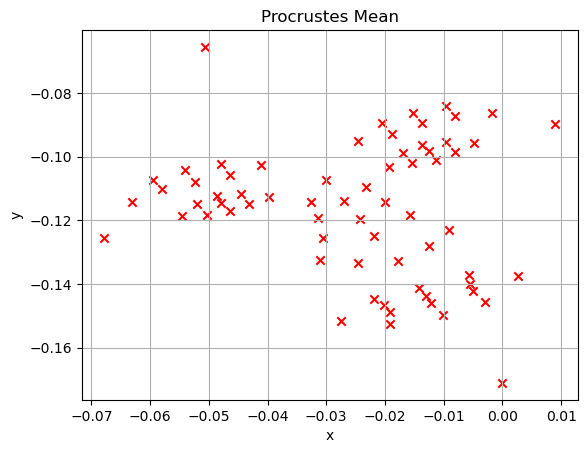

In [6]:
# w is an array with eigenvalues
# v is a matrix whose columns are eigenvectors
# the eigenvalue at w[i] is associated with the column v[:,i]
w, v = LA.eig(S)

maximum = np.abs(np.amax(w))
index = 0

for i in range(len(w)):
    if np.abs(w[i]) == maximum:
        index = i

# Procrustes mean
procrustes_mean = v[:, index]
coordsX = procrustes_mean.real
coordsY = procrustes_mean.imag

plt.figure()
plt.grid()
plt.scatter(coordsY, -coordsX, color='red', marker='x')
plt.title('Procrustes Mean')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


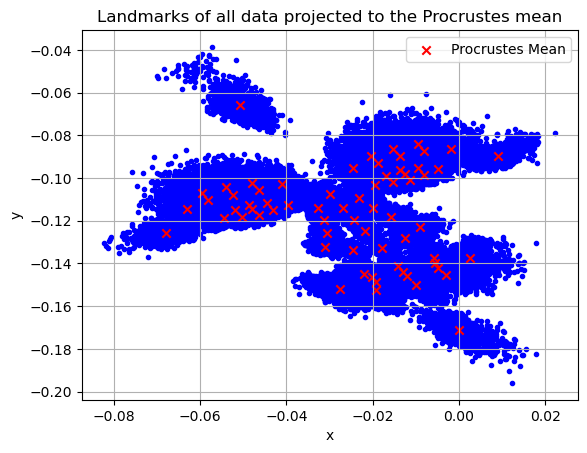

In [7]:
# Now we are going to align all the data landmarks to the Procrustes mean.

# Create a list to store the data adjusted to the Procrustes mean
procrustes_data = []

# This is the vector we are going to adjust to the Procrustes mean
w_tr_complex = np.zeros((len(data_list[0]), 1), dtype=complex)

for i in range(len(data)):
    data_point = data_list[i]
    for j in range(len(data_point)):
        w_tr_complex[j] = complex(data_point[j][0], data_point[j][1])

    # Project the landmarks to the Procrustes mean
    wp_tr = w_tr_complex * ((np.transpose(np.conj(w_tr_complex)) @ procrustes_mean) / ((np.transpose(np.conj(w_tr_complex)) @ w_tr_complex)))

    # Add each aligned landmark to the list
    procrustes_data.append(wp_tr)

    # Separate the X coordinates and the Y coordinates
    wp_tr_real = wp_tr.real
    wp_tr_imag = wp_tr.imag

    # Plot
    plt.scatter(wp_tr_imag, -wp_tr_real, color='blue', marker='.')

plt.grid()
plt.scatter(coordsY, -coordsX, color='red', marker='x', label='Procrustes Mean')
plt.title('Landmarks of all data projected to the Procrustes mean')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


### b) 2n-dimensional vector for each facial expression

With the aligned landmarks, we create a feature vecture of dimension 2x134 for each facial expression. 

The first feature corresponds to the horizontal component of landmark 1 of the facial expression.
The second feature corresponds to the vertical component of landmark 1 of the facial expression.
We repeat this procedure for the rest of the landmarks.


In [8]:
# Create a matrix where each column corresponds to each feature vector of each facial expression
feature_matrix = np.zeros((2 * len(procrustes_data[0]), len(procrustes_data)))

# Fill the matrix with the content of each vector, taking into account the consideration expressed above.
for i in range(len(procrustes_data)):
    data_point = procrustes_data[i]
    new_data_point = np.zeros((2 * len(data_point), 1))
    for j in range(len(data_point)):
        new_data_point[j * 2] = data_point.real[j]
        new_data_point[j * 2 + 1] = data_point.imag[j]
    feature_matrix[:, i] = column(new_data_point)


## c) Find the principal vectors

We take the first three principal vectors (i.e., the eigenvectors associated with the three largest eigenvalues of the covariance matrix), and plot them as if they were facial expressions. We indicate the variance contributed by each of these vectors to represent the data (i.e., the eigenvalue associated with each vector). 


In [9]:
# The first step is to find an estimate of the data mean. This mean will have the same dimension as each data x_i (each column of the feature matrix)
mu = np.zeros((np.shape(feature_matrix)[0], 1))

for i in range(np.shape(feature_matrix)[1]):
    x = column(feature_matrix[:, i])
    mu = mu + x

mu = (1 / np.shape(feature_matrix)[1]) * mu
print(f'Mean mu: \n {mu}')


Mean mu: 
 [[ 0.0980795 ]
 [-0.01255821]
 [ 0.09556425]
 [-0.00475817]
 [ 0.09503187]
 [-0.00954856]
 [ 0.09597561]
 [-0.0136305 ]
 [ 0.09862698]
 [-0.01689988]
 [ 0.10295927]
 [-0.01937467]
 [ 0.10178528]
 [-0.01540094]
 [ 0.10071807]
 [-0.01137685]
 [ 0.09819286]
 [-0.00804478]
 [ 0.11463835]
 [-0.04788374]
 [ 0.11246152]
 [-0.03974244]
 [ 0.11158098]
 [-0.04461474]
 [ 0.11234392]
 [-0.04870926]
 [ 0.11479877]
 [-0.0520005 ]
 [ 0.11876373]
 [-0.0545673 ]
 [ 0.11826709]
 [-0.05035121]
 [ 0.11715245]
 [-0.04642618]
 [ 0.11466151]
 [-0.04315331]
 [ 0.08614127]
 [-0.00177342]
 [ 0.08383891]
 [-0.00962815]
 [ 0.08596943]
 [-0.01536659]
 [ 0.0892752 ]
 [-0.02054622]
 [ 0.09492708]
 [-0.02460592]
 [ 0.09270881]
 [-0.01891323]
 [ 0.08924367]
 [-0.01380991]
 [ 0.08695119]
 [-0.00814671]
 [ 0.1023565 ]
 [-0.04115101]
 [ 0.10225203]
 [-0.04811336]
 [ 0.10403292]
 [-0.05417381]
 [ 0.10708404]
 [-0.05963887]
 [ 0.11424219]
 [-0.06315554]
 [ 0.11022758]
 [-0.05815855]
 [ 0.10769839]
 [-0.05244773]

Knowing the mean, the variance of the projected data is calculated as
$$\sigma_{u_1}^{2} = \frac{1}{m}\sum_{i=1}^{m} (u_1^Tx_i - u_1^T\mu)^2$$
Where $u_1$ is the first principal component associated with the largest eigenvalue of the covariance matrix of the data. It is important to remember that this value is a scalar, which we want to maximize to solve the PCA problem.

To calculate the covariance matrix $S_1$, the following equation is used:
$$S_1 = \frac{1}{m}\sum_{i=1}^{m}(x_i - \mu)(x_i-\mu)^T$$


In [10]:
# We proceed to calculate the estimation of the data covariance matrix.
arg = np.zeros((np.shape(feature_matrix[:, 0])[0], np.shape(feature_matrix[:, 0])[0]))

for i in range(np.shape(feature_matrix)[1]):
    x = column(feature_matrix[:, i])
    arg = arg + (x - mu) @ (x - mu).T

S1 = (1 / np.shape(feature_matrix)[1]) * arg


In [11]:
# Having the estimation of the covariance matrix, we proceed to find its eigenvalues and eigenvectors

# w1 is an array with eigenvalues.
# v1 is a matrix whose columns are normalized eigenvectors.
# the eigenvalue at w1[i] is associated with the column v1[:,i].
w1, v1 = LA.eig(S1)

# Find the 3 largest eigenvalues in the eigenvalues array. PrincipalComponents_3.
PC_3 = np.partition(w1, -3)[-3:]
# Using np.partition, we split the w1 array, and take the last 3 elements, which will be the largest eigenvalues.
print(f'Largest magnitude eigenvalues: {PC_3}')

# To find the eigenvectors associated with these eigenvalues, we need to find the indices of the eigenvalues we just found. For this, we use
# the np.argpartition function, which precisely returns an array with the indices of the specified partition.
indices = np.argpartition(w1, -3)[-3:]
print(f'Indices where these eigenvalues are located: {indices}')


Largest magnitude eigenvalues: [8.60550017e-05 1.04709463e-04 5.58696157e-04]
Indices where these eigenvalues are located: [2 1 0]


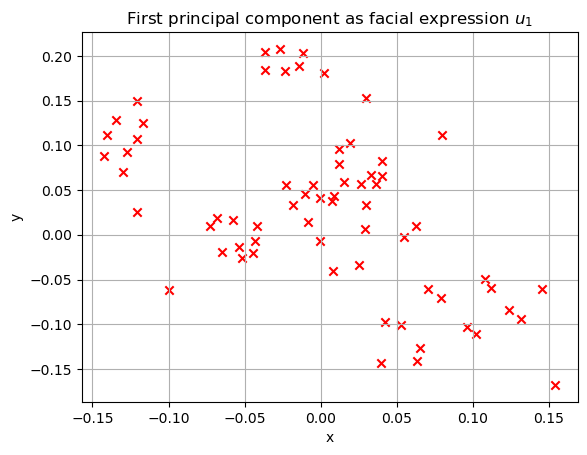

Variance contributed by this principal component: 0.0005586961569935755



In [12]:
# Now we are going to plot these three eigenvectors as if they were facial expressions (the indices in the index list are in ascending order; we need them in descending order (the largest first)).
u1 = v1[:, indices[2]]
u2 = v1[:, indices[1]]
u3 = v1[:, indices[0]]

X_u1 = []
Y_u1 = []

for i in range(len(u1)):
    # If it's even, it's an X coordinate, otherwise, it's a Y coordinate
    if i % 2 == 0:
        X_u1.append(u1[i])
    elif i % 2 != 0:
        Y_u1.append(u1[i])

# Plot of the first principal component as a facial expression
plt.figure()
plt.grid()
plt.scatter(np.array(Y_u1), -np.array(X_u1), color='red', marker='x')
plt.title('First principal component as facial expression $u_1$')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print(f'Variance contributed by this principal component: {w1[indices[2]]}\n')


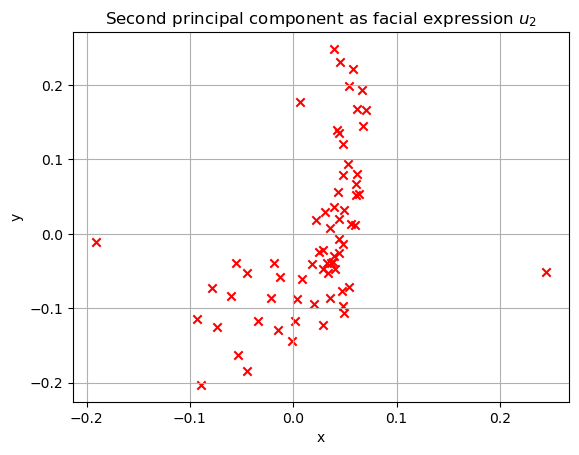

Variance contributed by this principal component: 0.00010470946339294094



In [13]:
X_u2 = []
Y_u2 = []

for i in range(len(u2)):
    # If it's even, it's an X coordinate, otherwise, it's a Y coordinate
    if i % 2 == 0:
        X_u2.append(u2[i])
    elif i % 2 != 0:
        Y_u2.append(u2[i])

# Plot of the second principal component as a facial expression
plt.figure()
plt.grid()
plt.scatter(np.array(Y_u2), -np.array(X_u2), color='red', marker='x')
plt.title('Second principal component as facial expression $u_2$')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print(f'Variance contributed by this principal component: {w1[indices[1]]}\n')


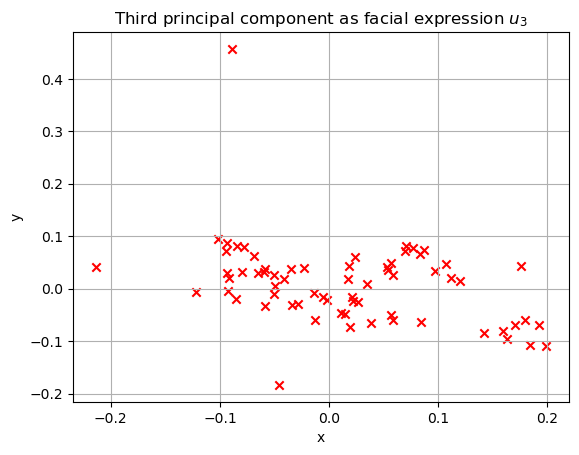

Variance contributed by this principal component: 8.605500174788834e-05



In [14]:
X_u3 = []
Y_u3 = []

for i in range(len(u3)):
    # If it's even, it's an X coordinate, otherwise, it's a Y coordinate
    if i % 2 == 0:
        X_u3.append(u3[i])
    elif i % 2 != 0:
        Y_u3.append(u3[i])

# Plot of the third principal component as a facial expression
plt.figure()
plt.grid()
plt.scatter(np.array(Y_u3), -np.array(X_u3), color='red', marker='x')
plt.title('Third principal component as facial expression $u_3$')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print(f'Variance contributed by this principal component: {w1[indices[0]]}\n')


#### It can be said that the principal vector $u_1$ represents the basis that captures the maximum variability of all facial expressions, while the next two vectors $u_2$ and $u_3$ are the vectors that follow, i.e., the bases that capture the second and third maximum variability of all facial expressions.


### d) Using the first two principal vectors, we map each facial expression to a subspace in two dimensions.

The first dimension corresponds to the projection of the greatest variance, and the second dimension corresponds to the second projection of greatest variance. Using the `plt.scatter()` function, we plot the 2-dimensional colored data, where the assigned color depends on the original labels associated with the emotions.


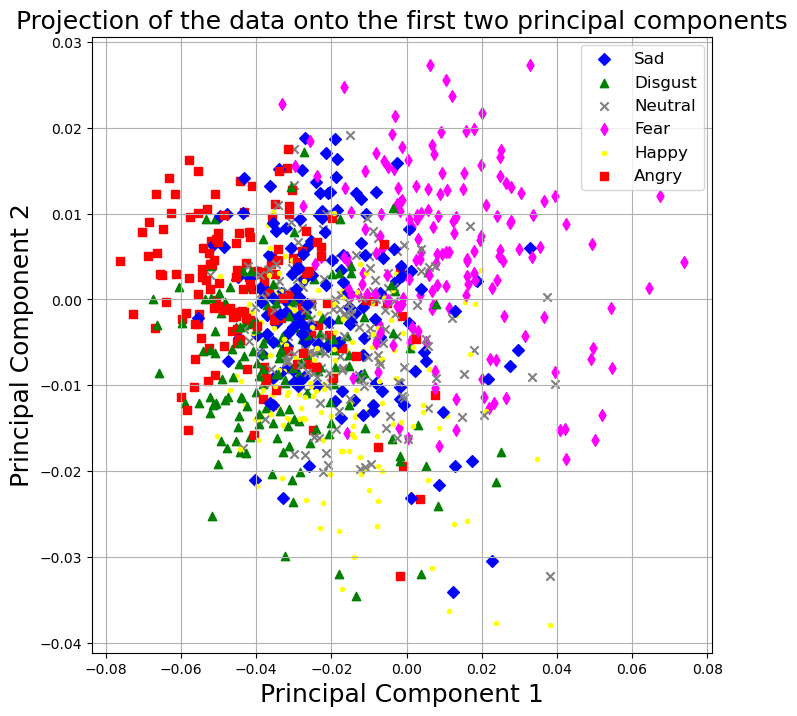

In [22]:
r = 2

# Create the vector z_i = Ar * x_i for each data point. We'll store them in a large matrix Z (134x974).
Z = np.zeros((r, len(procrustes_data)))

# Create the matrix Ar, a matrix whose rows are the transposed principal component vectors (u_i^T).
Ar = np.array([u1, u2])

# Fill the matrix Z with its corresponding z_i.
for i in range(np.shape(Z)[1]):
    z = Ar @ column(feature_matrix[:, i])
    Z[:, i] = z.T

# Create lists to know which indices within our data list correspond to which facial expression
neutral = []
indices_neutral = []

happy = []
indices_happy = []

sad = []
indices_sad = []

fear = []
indices_fear = []

angry = []
indices_angry = []

disgust = []
indices_disgust = []

# Fill these index lists
for file in os.listdir(dataDir):
    if (file[8] == "n"):
        neutral.append(file)
        indices_neutral.append(os.listdir(dataDir).index(file))
    elif (file[8] == "h"):
        happy.append(file)
        indices_happy.append(os.listdir(dataDir).index(file))
    elif (file[8] == "s"):
        sad.append(file)
        indices_sad.append(os.listdir(dataDir).index(file))
    elif (file[8] == "f"):
        fear.append(file)
        indices_fear.append(os.listdir(dataDir).index(file))
    elif (file[8] == "a"):
        angry.append(file)
        indices_angry.append(os.listdir(dataDir).index(file))
    elif (file[8] == "d"):
        disgust.append(file)
        indices_disgust.append(os.listdir(dataDir).index(file))

plt.figure(figsize=(8, 8))
plt.grid()

handles = []
labels = []

for j in range(np.shape(Z)[1]):
    if j in indices_neutral:
        handle = plt.scatter(Z[:, j][0], Z[:, j][1], color='grey', marker='x')
        if 'Neutral' not in labels:
            handles.append(handle)
            labels.append('Neutral')
    elif j in indices_happy:
        handle = plt.scatter(Z[:, j][0], Z[:, j][1], color='yellow', marker='.')
        if 'Happy' not in labels:
            handles.append(handle)
            labels.append('Happy')
    elif j in indices_sad:
        handle = plt.scatter(Z[:, j][0], Z[:, j][1], color='blue', marker='D')
        if 'Sad' not in labels:
            handles.append(handle)
            labels.append('Sad')
    elif j in indices_fear:
        handle = plt.scatter(Z[:, j][0], Z[:, j][1], color='magenta', marker='d')
        if 'Fear' not in labels:
            handles.append(handle)
            labels.append('Fear')
    elif j in indices_angry:
        handle = plt.scatter(Z[:, j][0], Z[:, j][1], color='red', marker='s')
        if 'Angry' not in labels:
            handles.append(handle)
            labels.append('Angry')
    elif j in indices_disgust:
        handle = plt.scatter(Z[:, j][0], Z[:, j][1], color='green', marker='^')
        if 'Disgust' not in labels:
            handles.append(handle)
            labels.append('Disgust')

plt.title('Projection of the data onto the first two principal components', fontsize=18)
plt.legend(handles, labels, fontsize=12)
plt.xlabel('Principal Component 1', fontsize=18)
plt.ylabel('Principal Component 2', fontsize=18)
plt.show()


In the above figure, the distribution of facial expression data in a 2-dimensional space is shown, grouped by their respective facial expressions. It can be observed that the data overlaps considerably towards the center of the plot, as these landmarks are very similar, even though they correspond to different facial expressions.

For the landmarks of the 'Fear' expression and some of the 'Angry' expression, it can be noticed that these differ much more than the others, as most of these data points are not overlapped with the other expressions. Additionally, it can be observed how there are expressions of certain facial expressions that are quite far from their respective clusters, due to having some particularity in their respective landmarks compared to the others of the same facial expression.
